In [1]:
import pandas as pd
import re
from nltk.corpus import stopwords
import string
from nltk.stem.snowball import SnowballStemmer

In [2]:
# Reading the data file into a DATAFRAME and checking the shape 
data=pd.read_csv('35.1AmazonMobileDataUncleaned.csv')
print(data.shape)

(71922, 2)


In [3]:
def datapreprocess(sen):
    
    sen = re.sub(r"didn't", "did not", sen)
    sen = re.sub(r"don't", "do not", sen)
    sen = re.sub(r"won't", "will not", sen)
    sen = re.sub(r"can't", "can not", sen)
    sen = re.sub(r"wasn't", "do not", sen)
    sen = re.sub(r"\'ve", " have", sen)
    sen = re.sub(r"\'m", " am", sen)
    sen = re.sub(r"\'ll", " will", sen)
    sen = re.sub(r"\'re", " are", sen)
    sen = re.sub(r"\'s", " is", sen)
    sen = re.sub(r"\'d", " would", sen)
    sen = re.sub(r"\'t", " not", sen)
    sen = re.sub(r"\'m", " am", sen)
    sen = re.sub(r"n\'t", " not", sen)
    
    p = set(string.punctuation) # p take all the punctuations, punctuations displayed below
    sen=sen.lower() # convert text to lower case
    words=sen.split() # split the text into words
    ctext=[]
    for i in range(10): #adding numbers from 0 - 9 to p 
        p.add(str(i))
    for i in words:
        t=''.join([x for x in i.encode("ascii","ignore").decode("ascii") if x not in p]) # ignoring non ascii charecters and numbers
        ctext.append(t)
    return " ".join([i for i in ctext]) # joining the cleaned words to text
    
    

stop=set(stopwords.words('english'))
print(stop)
stop.remove('no')
stop.remove('not')
stop.remove('nor')

preprocessed_essays = []
for sentance in data['uncleanedreview'].values:
    try:
        ctxt=datapreprocess(str(sentance))
        if len(ctxt)==0: raise()
        ctxt = ' '.join(e for e in ctxt.split() if e not in stop)
        preprocessed_essays.append(ctxt.lower().strip())
    except:
        preprocessed_essays.append("NAN")  
data['cleanedtext'] = preprocessed_essays
data.drop(data[data["cleanedtext"]=="NAN"].index,axis = 0,inplace = True) # deleting rows that have no text 
data=data.reset_index(drop='true') # after deleting rows index should be reset
data['decision']= data['decision'].replace('positive',1)
data['decision']= data['decision'].replace('negative',0)


s = SnowballStemmer("english")
p=[]
for i in data['cleanedtext'].values:
    k=[]
    for word in i.split():
        k.append(s.stem(word))
    l=' '.join(k)
    p.append(l)

data['j']=p

data.to_csv (r'AmazonMobileDataCleaned1.csv')

{'under', 'these', 'not', 'them', 'this', 'with', 'our', "don't", 'itself', 'been', 'who', 'at', 'both', 'is', 'in', 'those', 'before', 'hasn', 'if', 'couldn', 'shouldn', 'their', 'now', 'had', 'to', 'for', "doesn't", 'when', 'too', 'shan', 'further', 'be', "shouldn't", 'themselves', "won't", 'ourselves', 'same', 'mightn', 'should', 'aren', "aren't", 'doing', 'the', 'or', 'haven', 'than', 'some', 'because', 'y', 'it', "should've", 'll', "hasn't", 'few', 'once', 'myself', 'nor', 'herself', 'ma', 'weren', 'doesn', 'own', "weren't", 'him', 'while', 'just', 'your', "isn't", 'more', 'will', 'o', 'being', 'have', 'between', 'each', "mightn't", 'and', 'through', 'that', 's', 'from', 'about', 'where', 'was', 'as', 'there', 'so', 'yours', 'can', 'into', 'my', 'me', 'himself', 'her', 'how', 'until', 'i', 'yourselves', 'again', 'no', "didn't", 'most', "it's", 'a', 'what', 'mustn', 'hadn', 'she', 'of', 'an', 'he', 'won', 'does', 'theirs', 'having', 'any', 'such', 'against', 'why', 'we', "you'd", "

In [4]:
data=pd.read_csv('AmazonMobileDataCleaned1.csv',nrows=5000)
print(data.shape)
label = data['decision'].values
feedback = data.drop(['decision'], axis=1)
print(label.shape)
print(feedback.shape)
print("------------------------------")

# Divide data to raining and testing
from sklearn.model_selection import train_test_split
inputtrain, inputtest, outputtrain, outputtest = train_test_split(feedback, label, test_size=0.20, stratify=label)
print(inputtrain.shape)
print(inputtest.shape)
print(outputtrain.shape)
print(outputtest.shape)

(5000, 5)
(5000,)
(5000, 4)
------------------------------
(4000, 4)
(1000, 4)
(4000,)
(1000,)


In [5]:
# convert into Bag of Words
from sklearn.feature_extraction.text import CountVectorizer
vec = CountVectorizer(min_df=10,ngram_range=(1,4))
vec.fit(inputtrain['j'].values) # fit has to happen only on train data


train_cleanedtext = vec.transform(inputtrain['j'].values)
test_cleanedtext= vec.transform(inputtest['j'].values)

print("After vectorizations")
print(train_cleanedtext.shape)
print(test_cleanedtext.shape)
print(outputtrain.shape)
print(outputtest.shape)
print("...............................")

After vectorizations
(4000, 2808)
(1000, 2808)
(4000,)
(1000,)
...............................


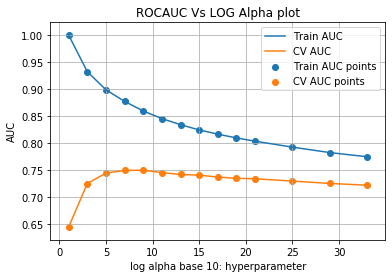

{'n_neighbors': 9}
0.7499535585742482


In [7]:
# Packages required
# some of the code taken from stack overflow
import math
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import matplotlib.pyplot as plt


neigh = KNeighborsClassifier(n_jobs=-1)

k=np.array([1,3,5,7,9,11,13,15,17,19,21,25,29,33]) # Different k values
tuned_parameters = {'n_neighbors' : k} # K values in a dictionary


clf = GridSearchCV(neigh, tuned_parameters, cv=5, scoring='roc_auc',return_train_score='true') 
clf.fit(train_cleanedtext, outputtrain)

results = pd.DataFrame.from_dict(clf.cv_results_)#please check the output of cv_results_
#  gridsearchcv execution will understand. concepts required KFold cross validation
results = results.sort_values(['param_n_neighbors'])

train_auc= results['mean_train_score']

cv_auc = results['mean_test_score'] 

k =  results['param_n_neighbors']



plt.plot(k, train_auc, label='Train AUC')# to connect lines to auc points


plt.plot(k, cv_auc, label='CV AUC')



plt.scatter(k, train_auc, label='Train AUC points')
plt.scatter(k, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("k: hyperparameter")
plt.ylabel("AUC")
plt.title("ROCAUC Vs LOG Alpha plot")
plt.grid()
plt.show()


print(clf.best_params_)# pick the best k value
print(clf.best_score_)



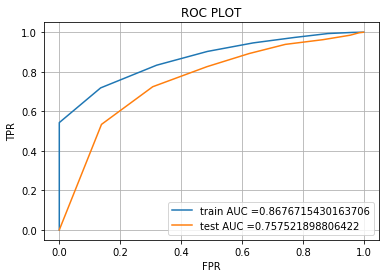

---------------------------------------------------
the maximum value of tpr*(1-fpr) 0.6209218623011726 for threshold 0.889
Train confusion matrix


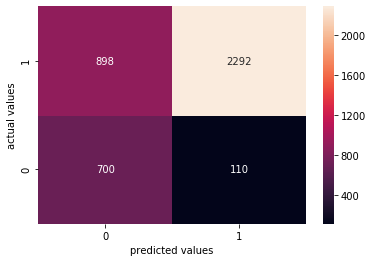

Test confusion matrix


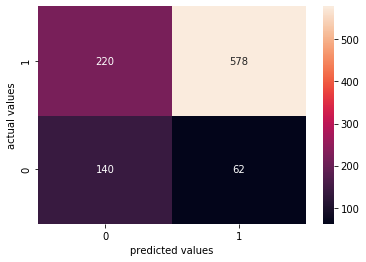

In [9]:
from sklearn.metrics import roc_curve, auc
import seaborn as sns

neigh = KNeighborsClassifier(n_neighbors=9)
neigh.fit(train_cleanedtext, outputtrain)



y_train_pred = neigh.predict_proba(train_cleanedtext)[:,1]    
y_test_pred = neigh.predict_proba(test_cleanedtext)[:,1]
#print(y_test_pred)
train_fpr, train_tpr, tr_thresholds = roc_curve(outputtrain, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(outputtest, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC PLOT")
plt.grid()
plt.show()


def bestthreshold(threshould, fpr, tpr):# function to predict best threshold
    t = threshould[np.argmax(tpr*(1-fpr))]
    
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predictusingbestt(proba, threshould):#prediction using best threshold
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

print("---------------------------------------------------")


from sklearn.metrics import confusion_matrix
best_t = bestthreshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")

ax=sns.heatmap(confusion_matrix(outputtrain, predictusingbestt(y_train_pred, best_t)),annot=True,fmt='d')
ax.set_ylim([0,2])

plt.ylabel('actual values')
plt.xlabel('predicted values')
plt.show()
print("Test confusion matrix")


bx=sns.heatmap(confusion_matrix(outputtest, predictusingbestt(y_test_pred, best_t)),annot=True,fmt='d')
bx.set_ylim([0,2])

plt.ylabel('actual values')
plt.xlabel('predicted values')
plt.show()

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer# TFIDF convertion

tfvec = TfidfVectorizer(min_df=10,ngram_range=(1,4))
tfvec.fit(inputtrain['j'].values)

tfidf_train_cleanedtext = tfvec.transform(inputtrain['j'].values)
tfidf_test_cleanedtext= tfvec.transform(inputtest['j'].values)

print("After vectorizations")
print(tfidf_train_cleanedtext.shape)
print(tfidf_test_cleanedtext.shape)
print(outputtrain.shape)
print(outputtest.shape)
print("...............................")


After vectorizations
(4000, 2808)
(1000, 2808)
(4000,)
(1000,)
...............................


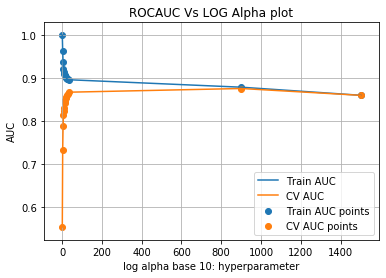

{'n_neighbors': 901}
0.875687913618948


In [11]:
# Packages required
# some of the code taken from stack overflow
import math
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import matplotlib.pyplot as plt


neigh = KNeighborsClassifier(n_jobs=-1)

k=np.array([1,3,5,7,9,11,13,15,17,19,21,25,29,33,901,1501]) # Different k values
tuned_parameters = {'n_neighbors' : k} # k values in a dictionary


clf = GridSearchCV(neigh, tuned_parameters, cv=5, scoring='roc_auc',return_train_score='true') 
clf.fit(tfidf_train_cleanedtext, outputtrain)

results = pd.DataFrame.from_dict(clf.cv_results_)#please check the output of cv_results_
#  gridsearchcv execution will understand. concepts required KFold cross validation
results = results.sort_values(['param_n_neighbors'])

train_auc= results['mean_train_score']

cv_auc = results['mean_test_score'] 

k =  results['param_n_neighbors']



plt.plot(k, train_auc, label='Train AUC')# to connect lines to auc points


plt.plot(k, cv_auc, label='CV AUC')



plt.scatter(k, train_auc, label='Train AUC points')
plt.scatter(k, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ROCAUC Vs LOG Alpha plot")
plt.grid()
plt.show()


print(clf.best_params_)# pick the best alpha value
print(clf.best_score_)



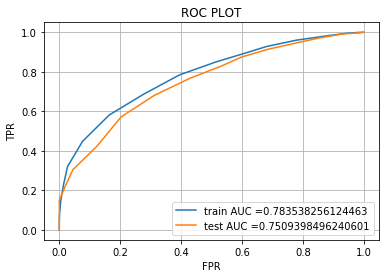

---------------------------------------------------
the maximum value of tpr*(1-fpr) 0.49627307558342043 for threshold 0.876
Train confusion matrix


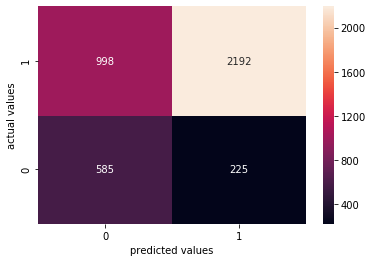

Test confusion matrix


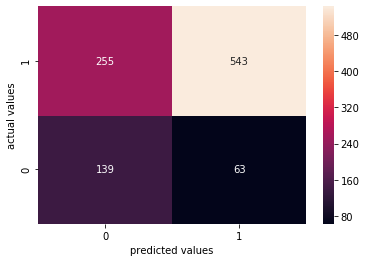

In [14]:
from sklearn.metrics import roc_curve, auc
import seaborn as sns

neigh = KNeighborsClassifier(n_neighbors=901)
neigh.fit(train_cleanedtext, outputtrain)



y_train_pred = neigh.predict_proba(tfidf_train_cleanedtext)[:,1]    
y_test_pred = neigh.predict_proba(tfidf_test_cleanedtext)[:,1]
#print(y_test_pred)
train_fpr, train_tpr, tr_thresholds = roc_curve(outputtrain, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(outputtest, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC PLOT")
plt.grid()
plt.show()


def bestthreshold(threshould, fpr, tpr):# function to predict best threshold
    t = threshould[np.argmax(tpr*(1-fpr))]
    
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predictusingbestt(proba, threshould):#prediction using best threshold
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

print("---------------------------------------------------")


from sklearn.metrics import confusion_matrix
best_t = bestthreshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")

ax = sns.heatmap(confusion_matrix(outputtrain, predictusingbestt(y_train_pred, best_t)),annot=True,fmt='d')
ax.set_ylim([0,2])

plt.ylabel('actual values')
plt.xlabel('predicted values')
plt.show()
print("Test confusion matrix")


bx=sns.heatmap(confusion_matrix(outputtest, predictusingbestt(y_test_pred, best_t)),annot=True,fmt='d')
bx.set_ylim([0,2])

plt.ylabel('actual values')
plt.xlabel('predicted values')
plt.show()

In [15]:
#AVG word2vec
from gensim.models import Word2Vec
import gensim

train_list=[]
for sent in inputtrain['j']:
    train_list.append(sent.split(' '))
w2vmodel= gensim.models.Word2Vec(train_list,min_count=10,size=50,workers=4)
print(w2vmodel.wv.most_similar('great'))


input_train_w2v = []; # the avg-w2v for each sentence/review is stored in this list
for sent in (inputtrain['j'].values): # for each review/sentence
    sentvec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    countwords =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2vmodel:
            vec = w2vmodel.wv[word]
            sentvec += vec
            countwords += 1
    if countwords != 0:
        sentvec /= countwords
    input_train_w2v.append(sentvec)
print(len(input_train_w2v))
print(len(input_train_w2v[0]))


input_test_w2v = []; # the avg-w2v for each sentence/review is stored in this list
for sent in (inputtest['j'].values): # for each review/sentence
    sentvec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    countwords =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2vmodel:
            vec = w2vmodel.wv[word]
            sentvec += vec
            countwords += 1
    if countwords != 0:
        sentvec /= countwords
    input_test_w2v.append(sentvec)
print(len(input_test_w2v))
print(len(input_test_w2v[0]))

print(input_test_w2v[0])

[('good', 0.9838542342185974), ('look', 0.978132426738739), ('well', 0.976892352104187), ('nice', 0.9707473516464233), ('fast', 0.9660959243774414), ('realli', 0.964410662651062), ('feel', 0.9614165425300598), ('pretti', 0.9599171876907349), ('size', 0.9549435973167419), ('amaz', 0.9531181454658508)]


C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).


4000
50


C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).


1000
50
[ 0.07264592 -0.06982251 -0.12530483  0.16824084 -0.17491283  0.03258525
 -0.12462568  0.22123308 -0.08750859 -0.0401285   0.06726262 -0.08732668
 -0.24140153  0.09841244 -0.28331716  0.33209932  0.25436213 -0.21896188
  0.11797306  0.09803447 -0.24307248 -0.07376293 -0.1860604   0.1107868
 -0.08798855  0.1023144   0.07922778  0.02050068  0.00216252  0.26311534
 -0.18203281 -0.25499019  0.00650826 -0.15849605  0.09935434  0.07073767
  0.07316773  0.10312822 -0.05362072  0.20788022 -0.09487435 -0.06920403
  0.16950483  0.0975104   0.03322217  0.13352786  0.28708901  0.30393533
 -0.00524787 -0.02159278]


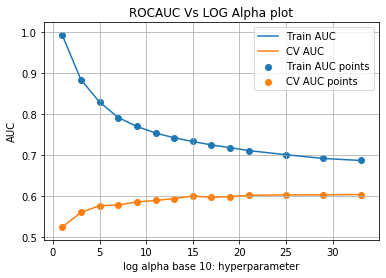

{'n_neighbors': 33}
0.6045038507682186


In [16]:
# Packages required
# some of the code taken from stack overflow
import math
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import matplotlib.pyplot as plt


neigh = KNeighborsClassifier(n_jobs=-1)

k=np.array([1,3,5,7,9,11,13,15,17,19,21,25,29,33]) # Different k values
tuned_parameters = {'n_neighbors' : k} # k values in a dictionary


clf = GridSearchCV(neigh, tuned_parameters, cv=5, scoring='roc_auc',return_train_score='true') 
clf.fit(input_train_w2v, outputtrain)

results = pd.DataFrame.from_dict(clf.cv_results_)#please check the output of cv_results_
#  gridsearchcv execution will understand. concepts required KFold cross validation
results = results.sort_values(['param_n_neighbors'])

train_auc= results['mean_train_score']

cv_auc = results['mean_test_score'] 

k =  results['param_n_neighbors']



plt.plot(k, train_auc, label='Train AUC')# to connect lines to auc points


plt.plot(k, cv_auc, label='CV AUC')



plt.scatter(k, train_auc, label='Train AUC points')
plt.scatter(k, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ROCAUC Vs LOG Alpha plot")
plt.grid()
plt.show()


print(clf.best_params_)# pick the best alpha value
print(clf.best_score_)



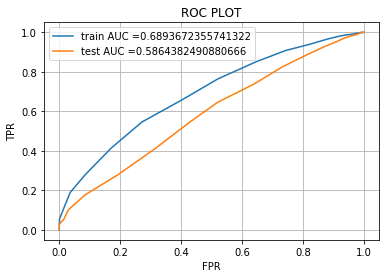

---------------------------------------------------
the maximum value of tpr*(1-fpr) 0.39776307132628974 for threshold 0.818
Train confusion matrix


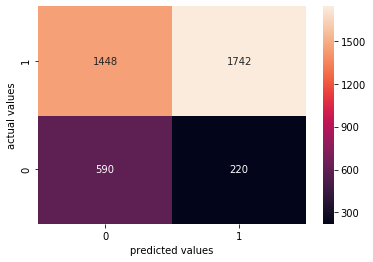

Test confusion matrix


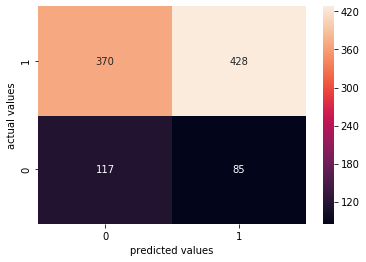

In [17]:
from sklearn.metrics import roc_curve, auc
import seaborn as sns

neigh = KNeighborsClassifier(n_neighbors=33)
neigh.fit(input_train_w2v, outputtrain)



y_train_pred = neigh.predict_proba(input_train_w2v)[:,1]    
y_test_pred = neigh.predict_proba(input_test_w2v)[:,1]
#print(y_test_pred)
train_fpr, train_tpr, tr_thresholds = roc_curve(outputtrain, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(outputtest, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC PLOT")
plt.grid()
plt.show()


def bestthreshold(threshould, fpr, tpr):# function to predict best threshold
    t = threshould[np.argmax(tpr*(1-fpr))]
    
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predictusingbestt(proba, threshould):#prediction using best threshold
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

print("---------------------------------------------------")


from sklearn.metrics import confusion_matrix
best_t = bestthreshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")

ax=sns.heatmap(confusion_matrix(outputtrain, predictusingbestt(y_train_pred, best_t)),annot=True,fmt='d')
ax.set_ylim([0,2])

plt.ylabel('actual values')
plt.xlabel('predicted values')
plt.show()
print("Test confusion matrix")


bx=sns.heatmap(confusion_matrix(outputtest, predictusingbestt(y_test_pred, best_t)),annot=True,fmt='d')
bx.set_ylim([0,2])

plt.ylabel('actual values')
plt.xlabel('predicted values')
plt.show()

In [18]:
#TFIDF word2vec
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec

tfvec = TfidfVectorizer(min_df=10)
tfvec.fit(inputtrain['j'].values)


train_list=[]
for sent in inputtrain['j']:
    train_list.append(sent.split(' '))
w2vmodel= gensim.models.Word2Vec(train_list,min_count=10,size=50,workers=4)


dictionary = dict(zip(tfvec.get_feature_names(), list(tfvec.idf_)))

tfidf_feat = tfvec.get_feature_names() 
w2v_feat=list(w2vmodel.wv.vocab)

train_sentence_list=[]
for sent in inputtrain['j']:
    train_sentence_list.append(sent.split(' '))

tfidf_train_vectors = []; 
row=0
for sent in (train_sentence_list): 
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2vmodel and word in tfidf_feat:
            vec = w2vmodel.wv[word]
            # tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_train_vectors.append(sent_vec)
    row += 1
print(row)



test_sentence_list=[]
for sent in inputtest['j']:
    test_sentence_list.append(sent.split(' '))

tfidf_test_vectors = []; 
row=0
for sent in (test_sentence_list): 
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2vmodel and word in tfidf_feat:
            vec = w2vmodel.wv[word]
            # tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_test_vectors.append(sent_vec)
    row += 1
print(row)



C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).


4000


C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:58: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).


1000


In [19]:
print(tfidf_train_vectors)


[array([ 0.21689604, -0.01819007, -0.12253387,  0.30812233, -0.19875395,
        0.16741443, -0.17290351,  0.49587185, -0.19732353, -0.04468734,
        0.0565691 , -0.07391637, -0.40070575,  0.17294122, -0.6667235 ,
        0.66329918,  0.42147539, -0.52671343,  0.23361308,  0.28299215,
       -0.36006123, -0.13446163, -0.34306823,  0.33586107, -0.12185755,
        0.23588002,  0.05705897, -0.01894264, -0.05694717,  0.35329103,
       -0.40706423, -0.53873166, -0.02703606, -0.42278211,  0.12897774,
        0.06234553,  0.23900387,  0.1612919 ,  0.02181954,  0.33923001,
       -0.14079434, -0.33191893,  0.43370466,  0.23878466, -0.02928745,
        0.20367438,  0.79005382,  0.67344445,  0.03805851, -0.06997316]), array([ 0.21822904, -0.06099565, -0.1569394 ,  0.36572197, -0.25913533,
        0.13983737, -0.21701147,  0.50605477, -0.21710767,  0.02429548,
        0.20839082, -0.19660806, -0.45586324,  0.18186887, -0.53833068,
        0.76896956,  0.52194309, -0.5342273 ,  0.28263671,  0

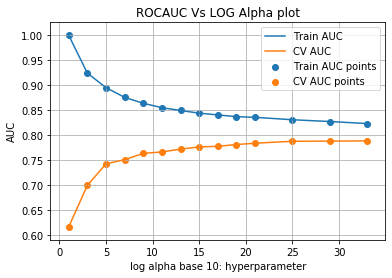

{'n_neighbors': 33}
0.7881835597352838


In [21]:
# Packages required
# some of the code taken from stack overflow
import math
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import matplotlib.pyplot as plt


neigh = KNeighborsClassifier(n_jobs=-1)

k=np.array([1,3,5,7,9,11,13,15,17,19,21,25,29,33]) # Different k values
tuned_parameters = {'n_neighbors' : k} # k values in a dictionary


clf = GridSearchCV(neigh, tuned_parameters, cv=5, scoring='roc_auc',return_train_score='true') 
clf.fit(tfidf_train_vectors, outputtrain)

results = pd.DataFrame.from_dict(clf.cv_results_)#please check the output of cv_results_
#  gridsearchcv execution will understand. concepts required KFold cross validation
results = results.sort_values(['param_n_neighbors'])

train_auc= results['mean_train_score']

cv_auc = results['mean_test_score'] 

k =  results['param_n_neighbors']



plt.plot(k, train_auc, label='Train AUC')# to connect lines to auc points


plt.plot(k, cv_auc, label='CV AUC')



plt.scatter(k, train_auc, label='Train AUC points')
plt.scatter(k, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ROCAUC Vs LOG Alpha plot")
plt.grid()
plt.show()


print(clf.best_params_)# pick the best alpha value
print(clf.best_score_)



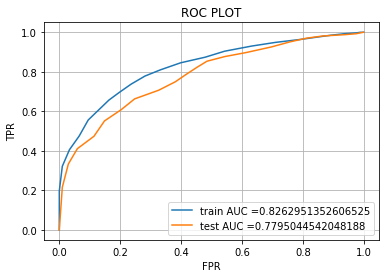

---------------------------------------------------
the maximum value of tpr*(1-fpr) 0.5634459537907814 for threshold 0.758
Train confusion matrix


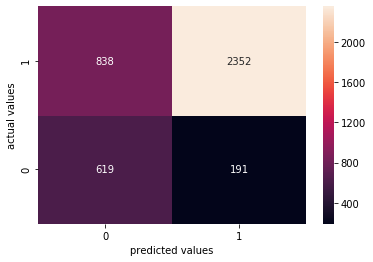

Test confusion matrix


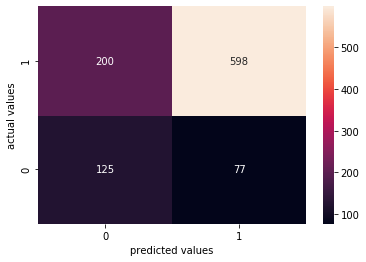

In [22]:
from sklearn.metrics import roc_curve, auc
import seaborn as sns

neigh = KNeighborsClassifier(n_neighbors=33)
neigh.fit(tfidf_train_vectors, outputtrain)



y_train_pred = neigh.predict_proba(tfidf_train_vectors)[:,1]    
y_test_pred = neigh.predict_proba(tfidf_test_vectors)[:,1]
#print(y_test_pred)
train_fpr, train_tpr, tr_thresholds = roc_curve(outputtrain, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(outputtest, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC PLOT")
plt.grid()
plt.show()


def bestthreshold(threshould, fpr, tpr):# function to predict best threshold
    t = threshould[np.argmax(tpr*(1-fpr))]
    
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predictusingbestt(proba, threshould):#prediction using best threshold
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

print("---------------------------------------------------")


from sklearn.metrics import confusion_matrix
best_t = bestthreshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")

ax=sns.heatmap(confusion_matrix(outputtrain, predictusingbestt(y_train_pred, best_t)),annot=True,fmt='d')
ax.set_ylim([0,2])

plt.ylabel('actual values')
plt.xlabel('predicted values')
plt.show()
print("Test confusion matrix")


bx=sns.heatmap(confusion_matrix(outputtest, predictusingbestt(y_test_pred, best_t)),annot=True,fmt='d')
bx.set_ylim([0,2])

plt.ylabel('actual values')
plt.xlabel('predicted values')
plt.show()